In [44]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
from tqdm import tqdm

# put smallest dimension in axis 0
def get_axes_maps(tensor):
    """
    This function takes a tensor and returns a mapping of axes and the reverse mapping.
    """
    # Create a mapping of axes
    axes_map = {i: (len(tensor.shape) - 1 - i) for i in range(len(tensor.shape))}
    # Create the reverse mapping
    reverse_map = {v: k for k, v in axes_map.items()}
    return axes_map, reverse_map

def transpose_tensor(tensor, axes_map):
    """
    This function takes a tensor and an axes map, and returns the transposed tensor.
    """
    # Get the list of axes for transposition
    axes = [axes_map[i] for i in range(len(tensor.shape))]
    # Perform the transposition
    return np.transpose(tensor, axes=axes)

default_slice = 50
def plot_slice(img, slice_num_1 =  default_slice):
    #pcolormesh and colorbar, slice on axis 0, in colorbar, denot it is HU (Hounsfield Unit)
    plt.pcolormesh(img[slice_num_1,:,:])
    plt.colorbar()
    plt.show()
def comparison_plot(img1, img2, slice_num_1 = default_slice):
    fig, ax = plt.subplots(1, 2)
    #for first use colormesh
    ax[0].imshow(img1[slice_num_1,:,:])
    #for second use imshow
    ax[1].imshow(img2[slice_num_1,:,:])
    plt.show()
def thorough_plot(img1, img2, num_slices=10, start=default_slice - 5, spacing=0.02):
    # num_slices rows and 2 columns, dense plot
    fig, ax = plt.subplots(num_slices, 2, figsize=(8, num_slices * 4))
    
    # Adjust horizontal spacing
    fig.subplots_adjust(wspace=spacing)
    
    for i in range(num_slices):
        ax[i, 0].imshow(img1[start + i, :, :])
        ax[i, 1].imshow(img2[start + i, :, :])
        # no coordinates for x and y
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
    
    plt.show()


In [45]:
def get_stats(ct_values):
    return {
        "values": ct_values,
        "min_val": np.min(ct_values),
        "max_val": np.max(ct_values),
        "mean_val": np.mean(ct_values),
        "std_val": np.std(ct_values),
        "median_val": np.median(ct_values),
        "percentile_5": np.percentile(ct_values, 5),
        "percentile_95": np.percentile(ct_values, 95)
    }
def get_info(ct_file_path, seg_file_path, cut_at_perrcentiles=True, cut_percentiles=(5, 95)):
    ct = nib.load(ct_file_path)
    seg = nib.load(seg_file_path)
    #get the data
    ct_img = ct.get_fdata()
    seg_img = seg.get_fdata()
    
    axes_map, reverse_map = get_axes_maps(ct_img)
    ct_img = transpose_tensor(ct_img, axes_map)
    seg_img = transpose_tensor(seg_img, axes_map)
    mask = seg_img != 0
    mask_indices = np.argwhere(mask)
    # get values of CT at those indices
    ct_values = ct_img[mask]
    #if cut_at_perrcentiles is True then cut the values
    if cut_at_perrcentiles:
        ct_values = np.clip(ct_values, np.percentile(ct_values, cut_percentiles[0]), np.percentile(ct_values, cut_percentiles[1]))
    return get_stats(ct_values)
ct_path = r"D:\nsclc\data\nnUNet_raw\Dataset004_Corrected\imagesTr"
seg_path = r"D:\nsclc\data\nnUNet_raw\Dataset004_Corrected\labelsTr"
ct_suffix = "_0000.nii.gz"
seg_suffix = ".nii.gz"

#get all the files in the directory ct_path
ct_files = os.listdir(ct_path)
seg_files = os.listdir(seg_path)
# remove the suffix
# sort the files
ct_files.sort()
seg_files.sort()

#zip the files
files = zip(ct_files, seg_files)
#iterate through the files
infos = []
count = 0
count_max = 1000
#for ct_file, seg_file in files: <- make tqdm
#for ct_file, seg_file in tqdm(files):
for n in tqdm(range(len(ct_files))):
    ct_file, seg_file = ct_files[n], seg_files[n]
    ct_file_path = os.path.join(ct_path, ct_file)
    seg_file_path = os.path.join(seg_path, seg_file)
    #load the image
    try:
        info = get_info(ct_file_path, seg_file_path, cut_at_perrcentiles=False)
        #add number of file as name which is the xxx in LUNG1-xxx.nii.gz in seg_file, so seg_file.split(".")[0][-3:] will give the number
        # info["name"] = seg_file.split(".")[0][-3:] <- to int
        info["name"] = int(seg_file.split(".")[0][-3:])
        
        infos.append(info)
        count += 1
        if count >= count_max:
            print("enough")
            break

    except:
        print(f"Error processing {ct_file_path}")
        continue
print("done")

  0%|          | 0/402 [00:00<?, ?it/s]

100%|██████████| 402/402 [04:14<00:00,  1.58it/s]

done


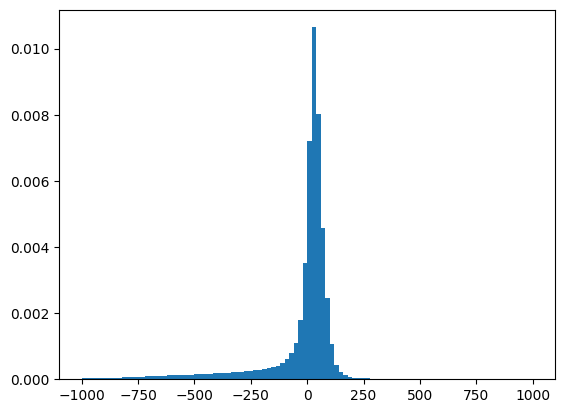

In [46]:
# get all values
values = [info["values"] for info in infos]
#flatten the list
values = np.concatenate(values)
#plot the histogram
#plt.hist(values, bins=100, range=(-1000, 1000))
#plt.show()
# use kde instead of histogram
plt.hist(values, bins=100, range=(-1000, 1000), density=True)
plt.show()

In [54]:
#get info of this values with the get_stats function
stats = get_stats(values)
#print the stats all but the values
for k, v in stats.items():
    if k != "values":
        print(f"{k}: {v}")
        


min_val: -1024.0
max_val: 3070.0
mean_val: -25.682674677994672
std_val: 176.50921009146367
median_val: 25.0
percentile_5: -439.0
percentile_95: 97.0


In [55]:
#sort the infos by the name in a list called infos_sorted
infos_sorted = sorted(infos, key=lambda x: x["name"])
# extract the names in a list
names = [info["name"] for info in infos]
#check that each name is paired with the correct info (info["name"])

for i, name in enumerate(names):
    assert name == infos_sorted[i]["name"]



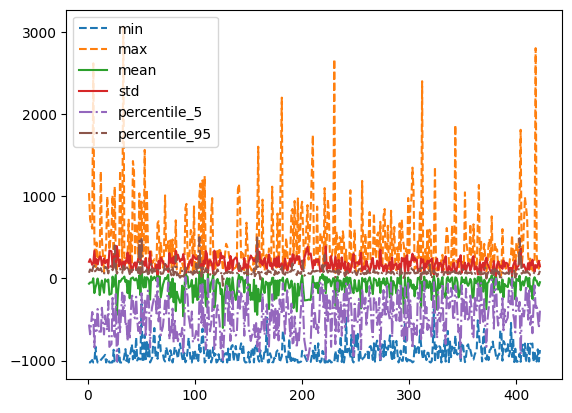

In [56]:
#plot min by name, also max, use legend
plt.plot(names, [info["min_val"] for info in infos_sorted], label="min", linestyle="--" )
plt.plot(names, [info["max_val"] for info in infos_sorted], label="max", linestyle="--")
#mean, std, percentile_5, percentile_95
plt.plot(names, [info["mean_val"] for info in infos_sorted], label="mean") 
plt.plot(names, [info["std_val"] for info in infos_sorted], label="std")
# all the linestyles are: 
plt.plot(names, [info["percentile_5"] for info in infos_sorted], label="percentile_5", linestyle="-.")
plt.plot(names, [info["percentile_95"] for info in infos_sorted], label="percentile_95", linestyle="-.")
#median
#plt.plot(names, [info["median_val"] for info in infos_sorted], label="median")

plt.legend()
plt.show()

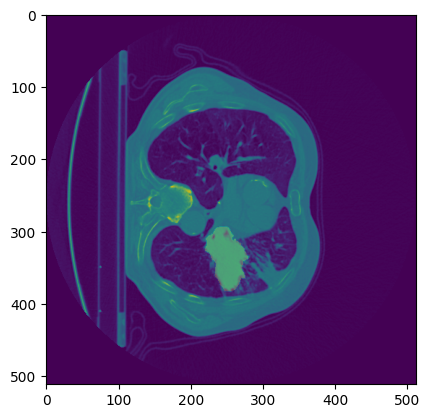

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
ct_path = r"D:\nsclc\data\nnUNet_raw\Dataset004_Corrected\imagesTr\LUNG1-001_0000.nii.gz"
seg_path = r"D:\nsclc\data\nnUNet_raw\Dataset004_Corrected\labelsTr\LUNG1-001.nii.gz"

ct = nib.load(ct_path)
seg = nib.load(seg_path)
# get the data
ct_img = ct.get_fdata()
seg_img = seg.get_fdata()


#mirror segmentation vertically


nib_seg = nib.Nifti1Image(seg_img, seg.affine, seg.header)
#save as test.nii.gz
nib.save(nib_seg, "test.nii.gz")

#slice_num_1 = 87 <- for lung1-088
slice_num_1 = 70
plt.imshow(ct_img[:, :, slice_num_1])
#superimpose the segmentation
plt.imshow(seg_img[:, :, slice_num_1], alpha=0.2)

In [51]:
npz_path = r"D:\nsclc\data\nnUNet_preprocessed\Dataset004_Corrected\nnUNetPlans_2d\LUNG1-088.npz"
npz = np.load(npz_path)
npz.files

['data', 'seg']

In [66]:
ct = npz["data"][0]
seg = npz["seg"][0]
ct.shape, seg.shape

((123, 512, 512), (123, 512, 512))

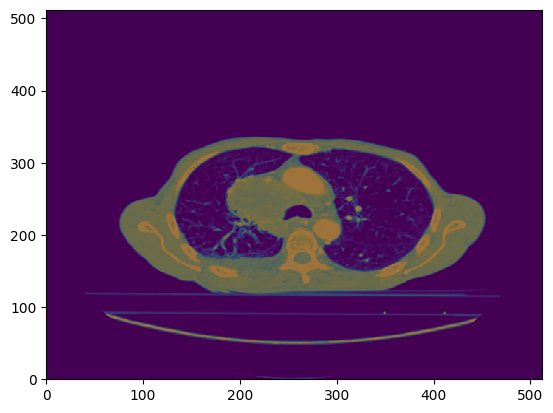

In [69]:
plt.pcolormesh(ct[slice_num_1])
plt.pcolormesh(seg[slice_num_1], alpha=0.5)
plt.show()